In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import root
#from scipy.optimize import brentq -- this is a solver for 1d systems

# The progression towards Alzheimer's disease described as a bistable switch arising from the positive loop between amyloids and Ca(2+) 

We will reproduce the bifurcation diagramme of figure 1.A. from 
https://pubmed.ncbi.nlm.nih.gov/23614875/

We study the simple model schematized in the figure here under 

<img src="./figures/abetac.jpg" width="200" height="100">

The 2 variables of the model are the concentrations of β-amyloids and the intracellular Ca2+ concentration. In the equations, these concentrations are denoted by $a$ and $c$, respectively:

$\frac{d c}{d t } = V_2 + k_\beta a^m - k_2 c$


$ \frac{d a}{d t } = V_1 + V_\alpha \frac{c^n}{K_\alpha^n + c^n} - k_1 a $




In [308]:
# Encode the model and 'default' parameters
V1 = 0.0065
V2 = 4
Va = 0.05
Ka = 120
n  = 2
k1 = 0.01
kb = 0.2
m  = 4
k2 = 0.1

params = np.array([V1,V2,Va,Ka,n,k1,kb,m,k2])

# model
def alzheimer_deriv(x,params=params): #x = [c,a]
    V1,V2,Va,Ka,n,k1,kb,m,k2 = params
    dc = V2 + kb*x[1]**m - k2*x[0]
    da = V1 + Va*x[0]**n / (Ka**n+x[0]**n) - k1*x[1]
    return np.array([dc, da])

## Bifurcation diagram

We will vary the parameter $V_1$ and solve for the steady state(s) for each value of $V_1$ considered. 

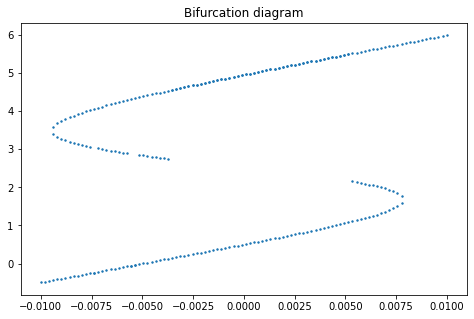

In [309]:
# array containing the values we scan over: 
V1var = np.linspace(-0.01,.01,100)

# empty list to store results
V1_list = []
sol_list = []

# a choice of method for the solver "root" 
method, options = 'hybr', {'maxfev': 100000}

for kk in range(len(V1var)):

    params[0]=V1var[kk]
    
    for start_point in [(10,1), (500,3), (1000,1)]:
    
        sol = root(alzheimer_deriv, start_point,args=(params,), method=method, options=options)
        #on the line above, we use args=(params,) to pass the parameters to the function alzheimer_deriv
        if sol.success: 
            V1_list.append(V1var[kk])
            sol_list.append(sol.x)

sols = np.asarray(sol_list)

plt.figure(figsize=(8,5))
plt.title('Bifurcation diagram')
plt.scatter(V1_list,sols[:,1],s=2) #here the "0" means I selected the variable "c", to get the bifurcation diagram for "a", replace "0" by "1"


<b> Remarks to improve the diagram </b>
    
1. to find the unstable branch, it would be wise to adapt the start_point of the solver iteratively. 
    
2. investigate different methods



## Fixed points 

In [300]:
# I redefined the system without the arguments here 
V1 = 0.0065
params[0]=V1
def alzheimer_deriv_without_params(x):
    return alzheimer_deriv(x,params)

mynewf = lambda x: alzheimer_deriv(x, params)

# a choice of method for the solver "root" 
method, options = 'hybr', {'maxfev': 100000}

root_1 = root(mynewf, [2000.,5.], method=method, options=options).x
root_2 = root(mynewf, [75.,2.], method=method, options=options).x
root_3 = root(mynewf, [0,0], method=method, options=options).x

print(root_1,root_2,root_3)

[2053.65371583    5.63298634] [74.24856566  2.03424425] [45.23870056  1.27217951]


## Stability of fixed points & Nullclines

To study the stability and compute nullclines, we wil rely on symbolic computation. The package used is sympy and it does not mix very well with numpy array. This is why we will redefine our model with sympy elements. 

In [301]:
import sympy as sym
from sympy.solvers import solve


def alzheimer_deriv_symbol(x): #x = [c,a]
    dc = V2 + kb*x[1]**m - k2*x[0]
    da = V1 + Va*x[0]**n / (Ka**n+x[0]**n) - k1*x[1]
    return sym.Matrix([dc,da])

c = sym.Symbol('c')
a = sym.Symbol('a')

Y=sym.Matrix([c,a]) 


# Near this fixed point, the system can be linearized:
# We have to define the Jacobian matrix:

jacX=alzheimer_deriv_symbol(Y).jacobian(Y)

# Evalute the jacobian on the fixed points:

for myroots in [root_1,root_2,root_3]:
    

    jacXeval =  jacX.subs({c:myroots[0],a:myroots[1]}) #subs(x,0) assigns the value 0 to the variable x. (here useless since the jacobian is a constant matrix)
    #transform in numpy array
    jacXeval_np = np.asarray(jacXeval,dtype=float)
    #and print
    print('For the root, ', myroots)
    print('trace: ', np.trace(jacXeval_np))
    print('det :',np.linalg.det(jacXeval_np)) 
    print('discr : ',np.linalg.det(jacXeval_np)**2-4*np.trace(jacXeval_np))


For the root,  [2053.65371583    5.63298634]
trace:  -0.11
det : 0.000976388351368083
discr :  0.4400009533342127
For the root,  [74.24856566  2.03424425]
trace:  -0.11
det : -0.0008158627455422491
discr :  0.44000066563201956
For the root,  [45.23870056  1.27217951]
trace:  -0.11
det : 0.0006033032039778697
discr :  0.44000036397475595


The first and third roots are stable nodes and the second is a saddle (therefore an unstable fixed point). 

In [305]:
#nullclines 

da_symbolic = V1 + Va*c**n / (Ka**n+c**n) - k1*a
dc_symbolic = V2 + kb*a**m - k2*c

# "a-nullcline" (velocity in "a" direction is null)
sol_a = solve(da_symbolic)
print('sol a is', sol_a)


# "c-nullcline" (velocity in "c" direction is null)
sol_c = solve(dc_symbolic)
print('sol c is', sol_c)

sol a is [{a: 0.05*(113.0*c**2 + 187200.0)/(c**2 + 14400.0)}]
sol c is [{c: 2.0*a**4 + 40.0}]


## Phase portrait 

In [306]:
#compute nullclines
ymin, ymax, xmin, xmax = 0, 7, -100, 2500


# a-nullcline
c_array = np.linspace(xmin, xmax, 100)
a_of_c_a_nullcline = [a.subs(sol_a[0]).subs({c:kk}) for kk in c_array]

# c-nullcline
a_array = np.linspace(ymin, ymax, 100)
c_of_a_c_nullcline = [c.subs(sol_c[0]).subs({a:kk}) for kk in a_array]

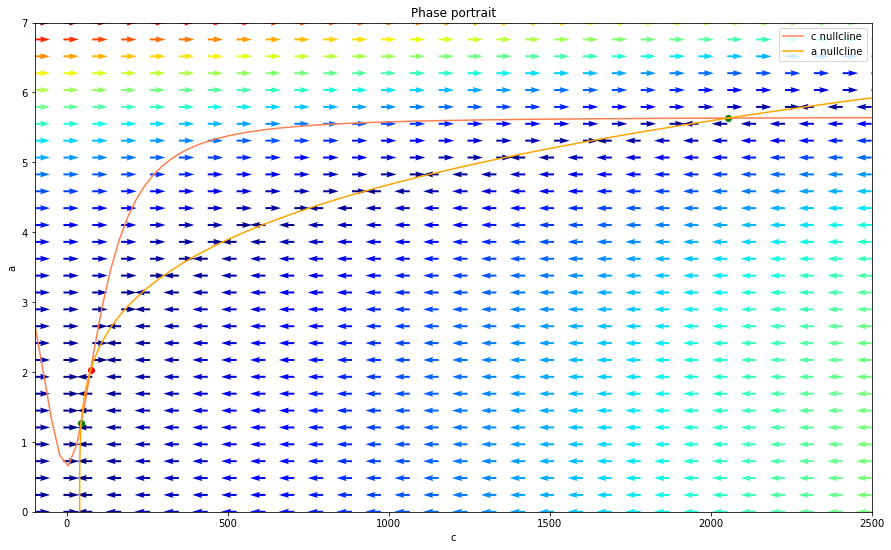

In [307]:


#create plot
fig = plt.figure(figsize=(15,9))
plt.xlabel("c")
plt.ylabel("a")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.title('Phase portrait')


#plot fixed points

plt.plot(root_1[0], root_1[1], 'go')#rem: here we swapped "x and y"
plt.plot(root_2[0], root_2[1], 'ro')
plt.plot(root_3[0], root_3[1], 'go')


#plot nullclines

plt.plot(c_array, a_of_c_a_nullcline, color = 'coral', label='c nullcline')
plt.plot(c_of_a_c_nullcline, a_array, color = 'orange', label='a nullcline')

#plot velocity vector field
c_array_grid = np.linspace(xmin, xmax, 30)
a_array_grid = np.linspace(ymin, ymax, 30)
#
X1 , Y1  = np.meshgrid(c_array_grid, a_array_grid)        # create a grid
DX1, DY1 = alzheimer_deriv([X1,Y1])             # compute growth rate on the grid
M = (np.hypot(DX1, DY1))                       # Norm of the growth rate 
M[ M == 0] = 1.                                # Avoid zero division errors 
                               
DX1 /= M                                       # Normalize each arrows (otherwise arrow near the center are too small)
DY1 /= M   

#-------------------------------------------------------
# Drow direction fields, using matplotlib 's quiver function
# I choose to plot normalized arrows and to use colors to give information on
# the growth speed
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='tail', cmap=plt.cm.jet)
plt.legend()
#plt.savefig('alzheimer_a_ifv_c.png')
plt.show() 



Remark: in this system the vertical velocity is very small with respect to the horizontal one.

In [41]:
#Appendix: Debug mode 


#here are different possible options for the solver, the last listed is the one actually used
method, options = 'krylov', {'nit': 1000}
method, options = 'lm', {}
method, options = 'hybr', {'maxfev': 10000}


debug = False


# array containing the values we scan over: 
V1var = np.linspace(-0.01,.01,100)

# array to store the location of the fixed points
my_roots = np.ones(len(V1var))

V1_list = []
sol_list = []
for kk in range(len(V1var)):

    params[0]=V1var[kk]
    
    for start_point in [(1, 10), (3, 500), (1, 1000)]:
    
        sol = root(alzheimer_deriv, start_point,args=(params,), method=method, options=options)
        if sol.success:
            V1_list.append(V1var[kk])
            sol_list.append(sol.x)

        else:
            if debug:
                print(f"V1 {V1var[kk]} failed {sol.message}")

        if debug:
            print(sol)
    
sols = np.asarray(sol_list)



Thanks to http://pdebuyl.be/ for improving the code! 